In [1]:
from numpy import asarray
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, plot_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, MaxPool2D, Flatten, Dense
import glob
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

##Output Preprocessing

In [2]:
data = pd.read_csv("/content/drive/MyDrive/house_table.txt", header=None, sep = " ")
price = data.iloc[:,-1:] #Tablo verimizden fiyatları çekiyoruz

##Photo Input Preprocessing

In [3]:
input_images_list = []

In [4]:
for housepath in glob.glob('/content/drive/MyDrive/Houses/*.jpg'):
  image = cv2.imread(housepath) #verileri okuyoruz
  res_image = cv2.resize(image,(300,300),cv2.INTER_AREA) #verilerin pixellerini resize ediyoruz
  input_images_list.append(res_image) #verilerimizi input images'e ekliyoruz

 

In [5]:
input_images = np.array(input_images_list).reshape((535,4,300,300,3))
images_train, images_test, price_train, price_test = train_test_split(input_images , price, test_size=0.33, shuffle=False)

In [6]:
photo_bath = []
photo_bed = []
photo_front = []
photo_kitch = []

#fotoğrafları bölümlerine göre 4'e ayırdım ve yukarıda oluşturduğum boş listeye attım
for i in range(len(images_train)):
  photo_bath.append(images_train[i,0])
  photo_bed.append(images_train[i,1])
  photo_front.append(images_train[i,2])
  photo_kitch.append(images_train[i,3])

#..._train adında arraylere dönüştürdüm
bath_train = np.array(photo_bath)
bed_train = np.array(photo_bed)
front_train = np.array(photo_front)
kitch_train = np.array(photo_kitch)

##Table Input Preprocessing

In [7]:
table_data = pd.read_csv("/content/drive/MyDrive/house_table.txt", header=None, sep=" ")

price = table_data.iloc[:,-1]
info_house = table_data.iloc[:,:-1]

table_x_train, table_x_test, table_y_train, table_y_test = train_test_split(info_house,price, test_size=0.33, shuffle=False)

table_x_train = table_x_train.values
table_x_test = table_x_test.values

#Price_train adında array'e dönüştürdüm
price_train = table_y_train.values
price_test = table_y_test.values

#x_train ve x_test için sütünlara göre bölme işlemi
room_train, floors_train, m2_train, loc_train = np.transpose(table_x_train) 
room_test, floors_test, m2_test, loc_test = np.transpose(table_x_test)





In [8]:
#table ve image verileri tek bir sözlük içinde topladım
x_train = [room_train,floors_train,m2_train,loc_train,bath_train, bed_train,front_train, kitch_train]

##MODEL

In [9]:
input_shape  = (1,)

input_room   = Input(shape=input_shape, name="input_room")
input_floors = Input(shape=input_shape, name="input_floors")
input_m2     = Input(shape=input_shape, name="input_m2")
input_loc    = Input(shape=input_shape, name="input_loc")

input_layer_table=[input_room,input_floors,input_m2,input_loc] #modele girecek tüm table inputlar
input_linear_list_table= [input_room,input_floors,input_m2] #lokasyon hariç diğer table inputları concate etmek için listede topluyorum
con_input_linear_list_table = Concatenate(axis=1)(input_linear_list_table) #lokasyon hariç diğer table inputları concate ediyorum




input_bath = Input(shape = (300,300,3),name="bath")
input_bed = Input(shape = (300,300,3),name="bed")
input_front = Input(shape = (300,300,3),name="front")
input_kitch = Input(shape = (300,300,3),name="kitch")

input_image_list = [input_bath,input_bed,input_front,input_kitch] #image inputları listede topluyorum


total_input_layer = [input_layer_table,input_image_list] #modele girecek image ve table inputların tamamı
total_input_layer

[[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_room')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_floors')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_m2')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_loc')>],
 [<KerasTensor: shape=(None, 300, 300, 3) dtype=float32 (created by layer 'bath')>,
  <KerasTensor: shape=(None, 300, 300, 3) dtype=float32 (created by layer 'bed')>,
  <KerasTensor: shape=(None, 300, 300, 3) dtype=float32 (created by layer 'front')>,
  <KerasTensor: shape=(None, 300, 300, 3) dtype=float32 (created by layer 'kitch')>]]

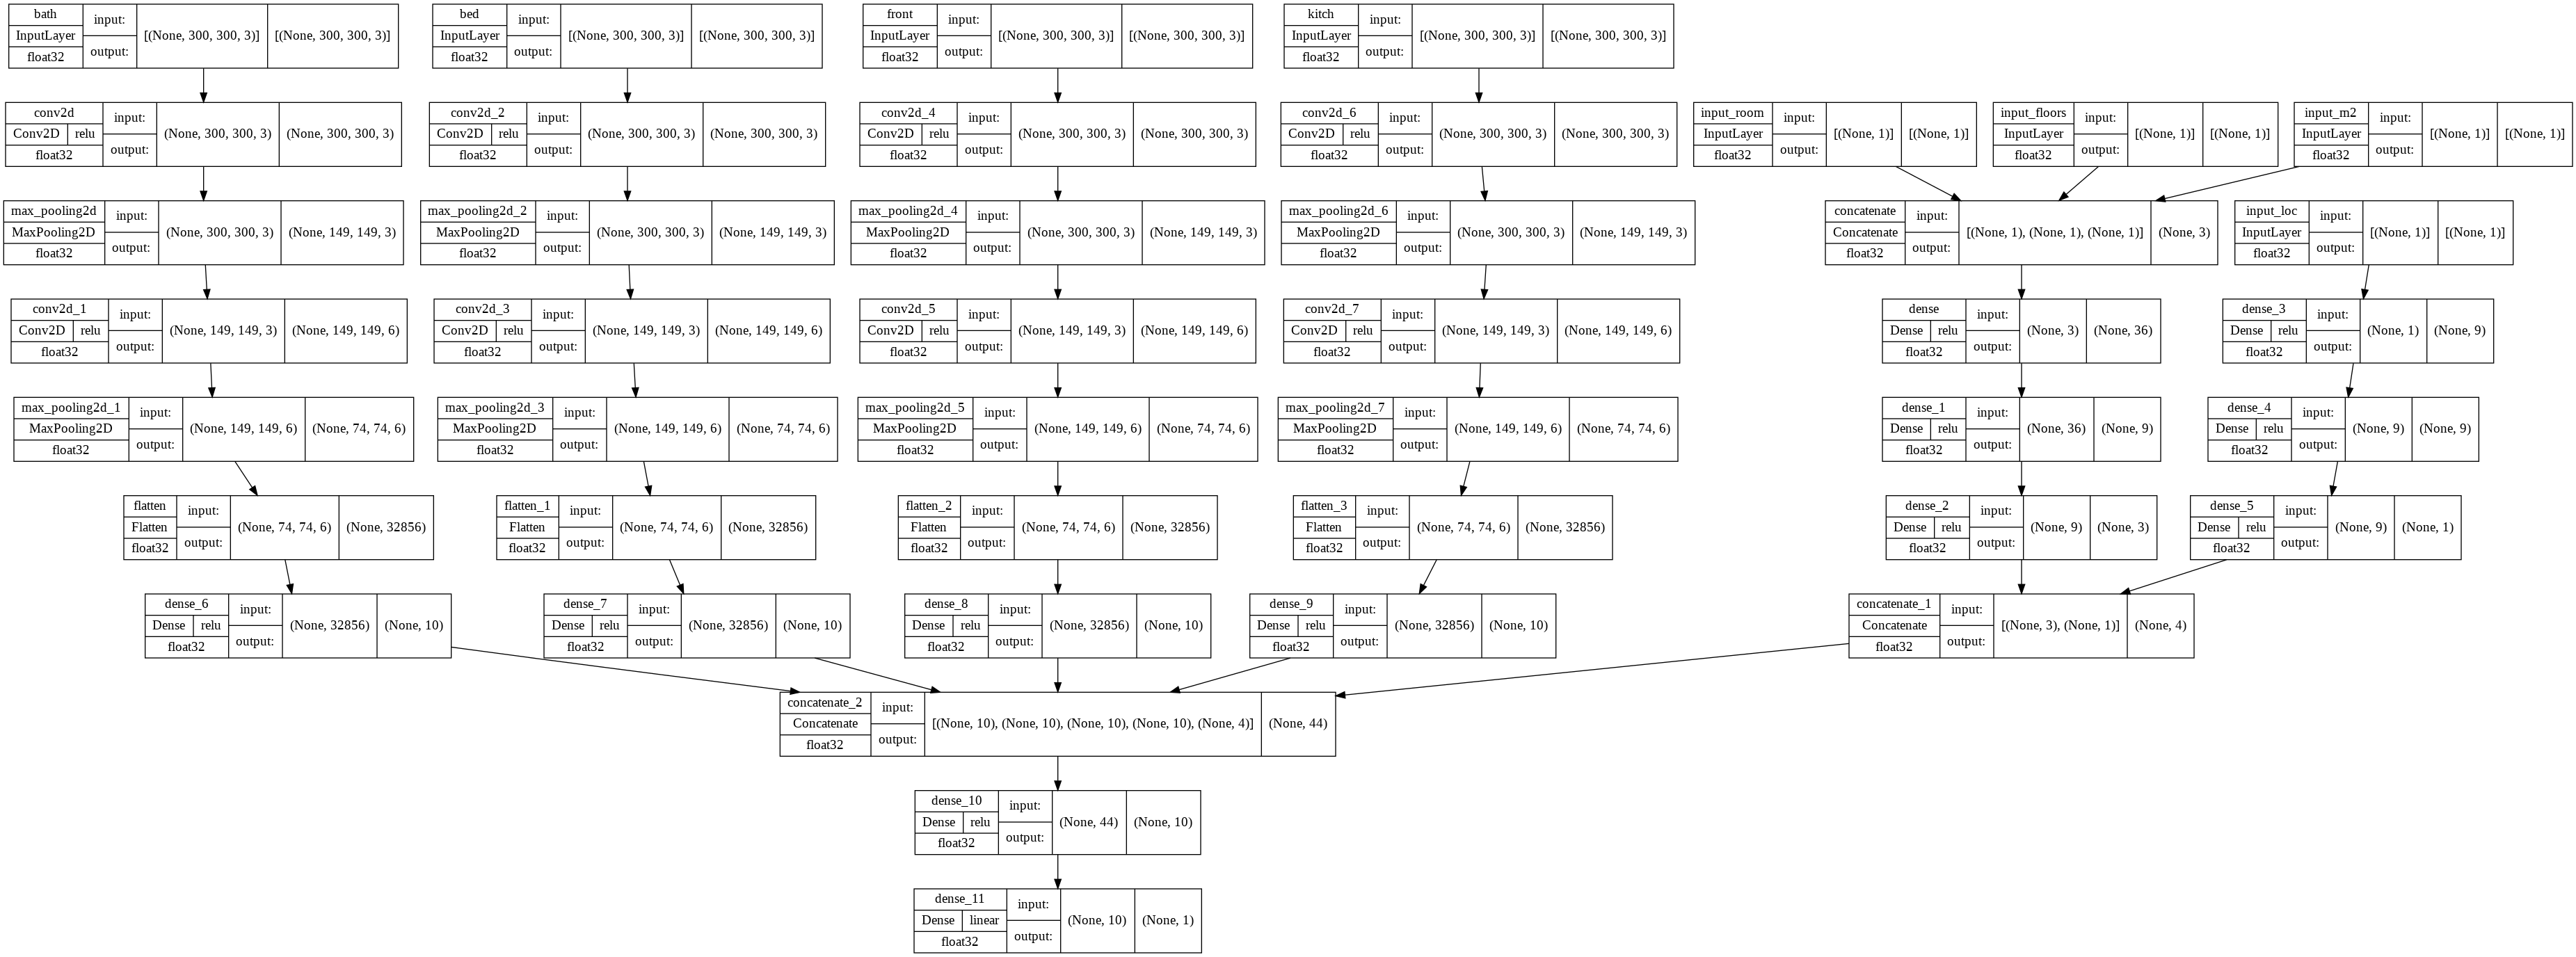

In [10]:
##TABLE 

table_l1 =  Dense(36,activation="relu")(con_input_linear_list_table)

table_l2 =  Dense(9,activation="relu")(table_l1)

table_l3 =  Dense(3,activation="relu")(table_l2)

table_l4 =  Dense(9,activation="relu")(input_loc)

table_l5 =  Dense(9,activation="relu")(table_l4)

table_l6 =  Dense(1,activation="relu")(table_l5)

con_table = Concatenate(axis=1)([table_l3,table_l6])


#İMAGES BATH

bath_l1 = Conv2D(
    filters = 3,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'same', activation="relu")(input_bath)

bath_max1 = MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(bath_l1)

bath_l2 = Conv2D(
    filters = 6,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'same', activation="relu")(bath_max1)

bath_max2 = MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(bath_l2)

flatten_bath = Flatten()(bath_max2)

#İMAGES BED

bed_l1 = Conv2D(
    filters = 3,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'same', activation="relu")(input_bed)

bed_max1 = MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(bed_l1)

bed_l2 = Conv2D(
    filters = 6,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'same', activation="relu")(bed_max1)

bed_max2 = MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(bed_l2)

flatten_bed = Flatten()(bed_max2)

#İMAGES FRONT

front_l1 = Conv2D(
    filters = 3,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'same', activation="relu")(input_front)

front_max1 = MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(front_l1)

front_l2 = Conv2D(
    filters = 6,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'same', activation="relu")(front_max1)

front_max2 = MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(front_l2)

flatten_front = Flatten()(front_max2)

#İMAGES KITCH

kitch_l1 = Conv2D(
    filters = 3,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'same', activation="relu")(input_kitch)

kitch_max1 = MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(kitch_l1)

kitch_l2 = Conv2D(
    filters = 6,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'same', activation="relu")(kitch_max1)

kitch_max2 = MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(kitch_l2)

flatten_kitch = Flatten()(kitch_max2)




dense_layer_bath = Dense(10, activation="relu")(flatten_bath)

dense_layer_bed = Dense(10, activation="relu")(flatten_bed)

dense_layer_front = Dense(10, activation="relu")(flatten_front)

dense_layer_kitch = Dense(10, activation="relu")(flatten_kitch)

room_table_con_layer = Concatenate()([dense_layer_bath, dense_layer_bed, dense_layer_front, dense_layer_kitch, con_table])

room_table_dense_layer_1 = Dense(10, activation="relu")(room_table_con_layer)

room_table_dense_layer_2 = Dense(1, activation="linear")(room_table_dense_layer_1)


model = Model(total_input_layer,room_table_dense_layer_2)

plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True)


In [11]:
model.compile(optimizer="adam",
              loss=("MeanAbsoluteError"),
              metrics=("mean_absolute_error"))

In [ ]:
model.fit(x = x_train, y = price_train,
          batch_size=10,
          epochs=10)

Epoch 1/10
36/36 [==============================] - 55s 1s/step - loss: 616668.3125 - mean_absolute_error: 616668.3125
Epoch 2/10
36/36 [==============================] - 54s 2s/step - loss: 341506.1562 - mean_absolute_error: 341506.1562
Epoch 3/10
36/36 [==============================] - 54s 2s/step - loss: 324379.8125 - mean_absolute_error: 324379.8125
Epoch 4/10
36/36 [==============================] - 54s 2s/step - loss: 322566.5000 - mean_absolute_error: 322566.5000
Epoch 5/10
36/36 [==============================] - 54s 2s/step - loss: 322205.7188 - mean_absolute_error: 322205.7188
Epoch 6/10
36/36 [==============================] - 54s 2s/step - loss: 322839.8750 - mean_absolute_error: 322839.8750
Epoch 7/10
36/36 [==============================] - 54s 2s/step - loss: 322027.7812 - mean_absolute_error: 322027.7812
Epoch 8/10
36/36 [==============================] - 54s 2s/step - loss: 323149.5938 - mean_absolute_error: 323149.5938
Epoch 9/10
36/36 [==============================